In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import cv2
import numpy as np
from tqdm.notebook import tqdm

In [26]:
if torch.cuda.is_available():
    device = toch.device("cuda:0")
    print("running on GPU")
else:
    device = torch.device("cpu")
    print("running on CPU")

running on CPU


In [27]:
REBUILD_DATA = False

class CatsVSDogs():
    IMG_SIZE=50
    training_data = []
    CATS = "PetImages/Cat"
    DOGS = "PetImages/Dog"
    LABELS = {CATS: 0, DOGS: 1}
    catcount=0
    dogcount=0
    
    def make_training_data(self):
        for label in self.LABELS:
            for f in tqdm(os.listdir(label)):
                try:
                    path = os.path.join(label, f)
                    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                    self.training_data.append((np.array(img), np.eye(2)[self.LABELS[label]]))

                    if (label==self.CATS):
                        self.catcount+=1
                    else:
                        self.dogcount+=1
                except Exception as e:
                    pass

        np.random.shuffle(self.training_data)
        np.save("training_data.pyn", self.training_data)
        print(f"CATS: {self.catcount}")
        print(f"DOGS: {self.dogcount}")
    
if REBUILD_DATA:
    catsvsdogs = CatsVSDogs()
    catsvsdogs.make_training_data()

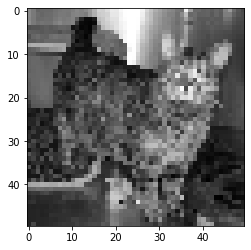

[1. 0.]


In [28]:
import matplotlib.pyplot as plt

#load data
training_data = np.load("training_data.npy", allow_pickle=True)

#show
idx=10
plt.imshow(training_data[idx][0], cmap="gray")
plt.show()
print(training_data[idx][1])


In [29]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)
        
        self._to_linear = None
        x = torch.rand(50, 50).view(-1, 1, 50, 50)
        self.convs(x)
        
        self.fc1 = nn.Linear(self._to_linear, 512)
        #if we add these two layers, the network doesn't learn at all !!
        #self.fc2 = nn.Linear(512, 256)
        #self.fc3 = nn.Linear(256, 64)
        self.fc4 = nn.Linear(512, 2)
    
    def convs(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2,2))
        
        if self._to_linear == None:
            self._to_linear = x[0].shape[0] * x[0].shape[1] * x[0].shape[2]
        
        return x
    
    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        
        x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        #x = F.relu(self.fc3(x))
        x = self.fc4(x)
        
        return F.softmax(x, dim=1)

net = Net().to(device)
net

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=2, bias=True)
)

In [30]:
#preparing the data

X = torch.Tensor([data[0] for data in training_data]).view(-1, 50, 50)
X = X/255.0
y = torch.Tensor([data[1] for data in training_data])

#train_test split
VAL_PCT = 0.1  # 10% of our data for validation
val_size = int(len(X)*VAL_PCT)

X_test = X[0:val_size]
y_test = y[0:val_size]
X_train = X[val_size:]
y_train = y[val_size:]

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

Training set size: 22452
Test set size: 2494


In [31]:
#train

BATCH_SIZE=100
EPOCHS=1
def train():
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    loss_function = nn.MSELoss()
    for epoch in range(EPOCHS):

        for i in tqdm(range(0, len(X_train), BATCH_SIZE)):
            X_batch = X_train[i:i+BATCH_SIZE].view(-1, 1, 50, 50).to(device)
            y_batch = y_train[i:i+BATCH_SIZE].to(device)

            net.zero_grad()
            predictions = net(X_batch)
            loss = loss_function(predictions, y_batch)
            loss.backward()
            optimizer.step()
        print(loss)

train()



tensor(0.2430, grad_fn=<MseLossBackward>)


In [34]:
#test 1
def test():
    correct=0
    total=0
    with torch.no_grad():
        for i in tqdm(range(0, len(X_test), BATCH_SIZE)):
            X_batch = X_test[i:i+BATCH_SIZE].view(-1, 1, 50, 50)
            y_batch = y_test[i:i+BATCH_SIZE]
            predictions = net(X_batch.view(-1, 1, 50, 50))
            for idx, prediction in enumerate(predictions):
                if (torch.argmax(prediction) == torch.argmax(y_batch[idx])):
                    correct+=1
                total+=1

    print(f"Accuracy: {np.round(correct/total*100, decimals=3)}%")

test()
            


Accuracy: 64.876%


In [35]:
#test 2 (if basically the same thing, without using batches)

def test2():
    correct=0
    total=0

    with torch.no_grad():
        for i in tqdm(range(len(X_test))):
            X = X_test[i].view(-1, 1, 50, 50)
            output = net(X)
            predicted_class = torch.argmax(output)
            real_class = torch.argmax(y_test[i])
            #print(f"Real class: {real_class} | Predicted class: {predicted_class}")
            if (predicted_class == real_class):
                correct+=1
            total+=1

    print(f"Accuracy: {np.round(correct/total*100, decimals=3)}%")

test2()


Accuracy: 64.876%
